In [2]:
# Importing libraries 

In [3]:
import pandas as pd
import librosa
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import time
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
import librosa.display  # Add this import for visualization functions
import tensorflow as tf

In [ ]:
# Setting the path 

In [5]:

metadata_path = r"C:\Users\yashm\Downloads\New folder (2)\UrbanSound8K\metadata\UrbanSound8K.csv"
metadata = pd.read_csv(metadata_path)
base_dir = r"C:\Users\yashm\Downloads\New folder (2)\UrbanSound8K\audio"
metadata['filepath'] = metadata.apply(
    lambda row: os.path.join(base_dir, f"fold{row['fold']}", row['slice_file_name']),
    axis=1
)

In [ ]:
# Random samples for data visualization(Commented)


In [ ]:

# Select 10 random samples (one per class)
#random_samples = metadata.groupby('class').sample(1, random_state=42)
#audio_files = random_samples['filepath'].tolist()
#labels = random_samples['class'].tolist()





In [ ]:
# Create Waveform Grid Visualization

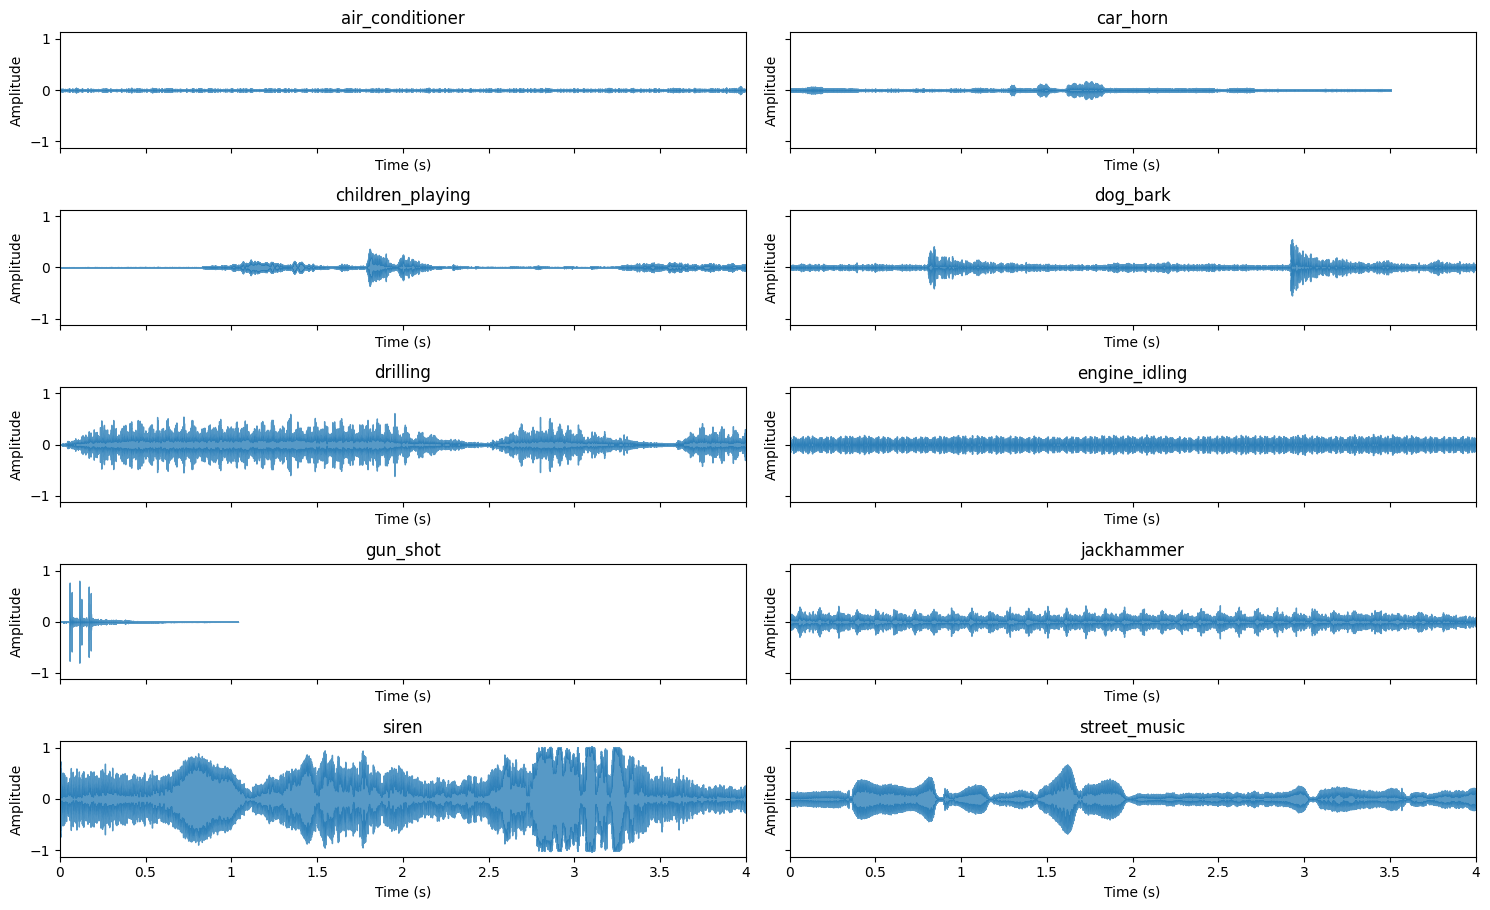

In [17]:


num_classes = len(labels)
rows = num_classes // 2 + (num_classes % 2 > 0)
fig, axs = plt.subplots(rows, 2, figsize=(15, 2*rows), sharex=True, sharey=True)

for i, (path, label) in enumerate(zip(audio_files, labels)):
  
    y, sr = librosa.load(path)
   
    row = i // 2
    col = i % 2
    
    # Plot waveform
    ax = axs[row, col] if rows > 1 else axs[col]
    librosa.display.waveshow(y, sr=sr, ax=ax, alpha=0.75)
    ax.set_title(label, fontsize=12)
    ax.set_xlabel('Time (s)', fontsize=10)
    ax.set_ylabel('Amplitude', fontsize=10)
    ax.set_xlim(0, len(y)/sr)  # Fix x-axis limits

if num_classes % 2 != 0:
    fig.delaxes(axs[-1, -1])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# Spectrogram Visualization

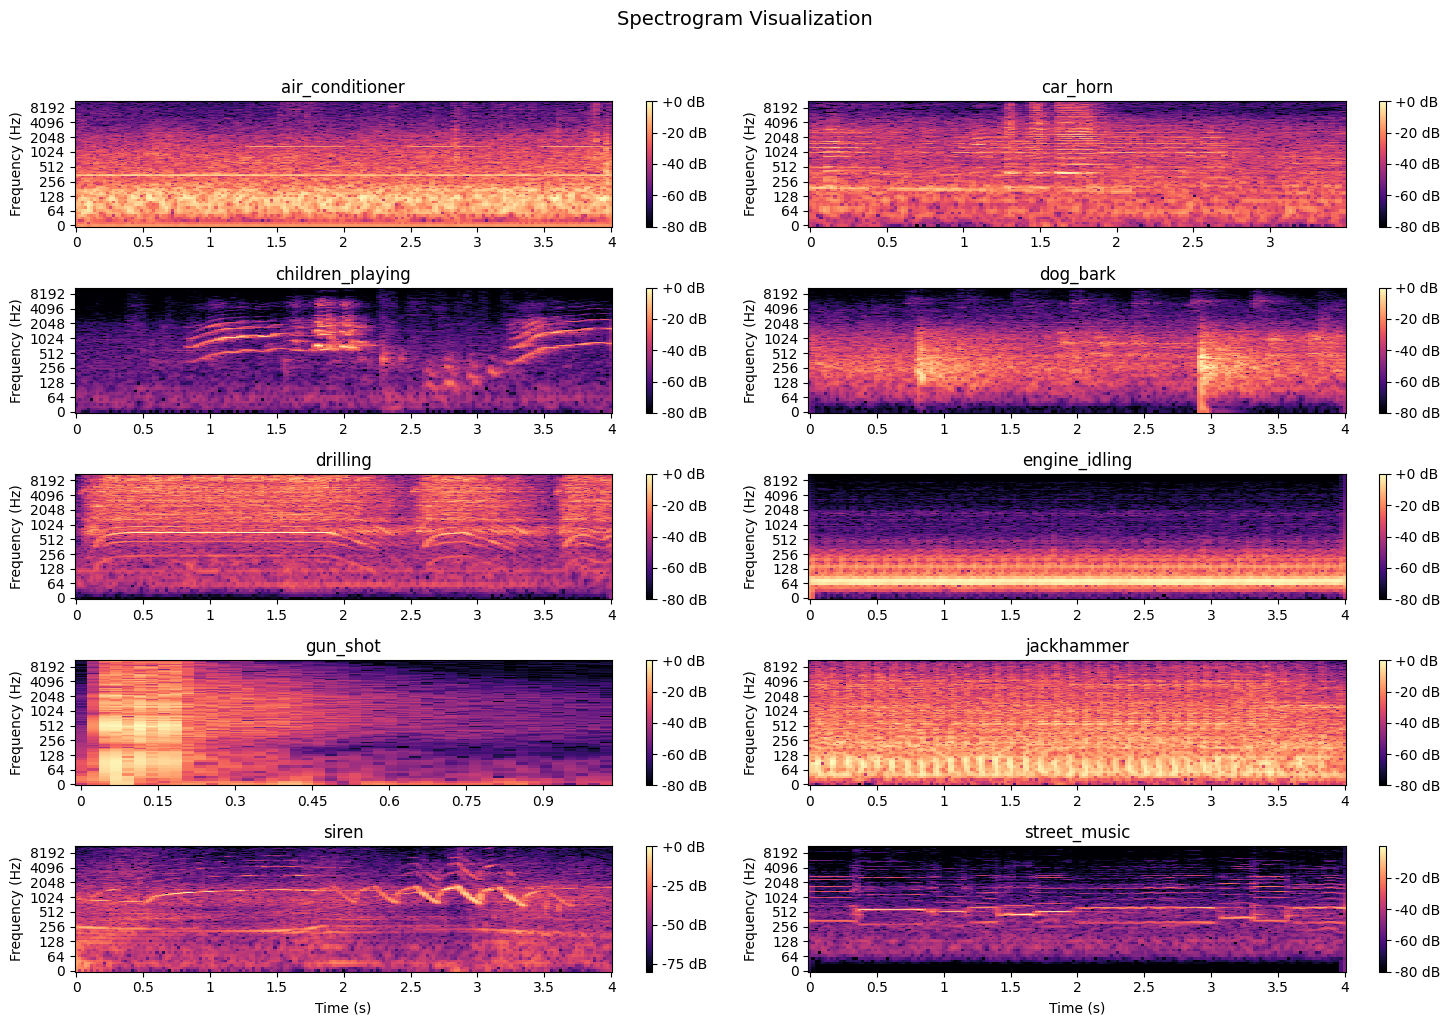

In [22]:
rows = (len(labels) + 1) // 2
fig, axs = plt.subplots(rows, 2, figsize=(15, 2 * rows))

for i, (path, label) in enumerate(zip(audio_files, labels)):
    y, sr = librosa.load(path)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    ax = axs[i // 2, i % 2] if rows > 1 else axs[i % 2]

    # Plot spectrogram
    img = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', ax=ax)
    ax.set_title(label, fontsize=12)
    ax.set_xlabel('Time (s)' if i // 2 == rows - 1 else '', fontsize=10)
    ax.set_ylabel('Frequency (Hz)', fontsize=10)

    fig.colorbar(img, ax=ax, format='%+2.0f dB')

# Remove empty subplots if needed
if len(labels) % 2 != 0:
    fig.delaxes(axs.flatten()[-1])

plt.suptitle('Spectrogram Visualization', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# MFCC Visualization

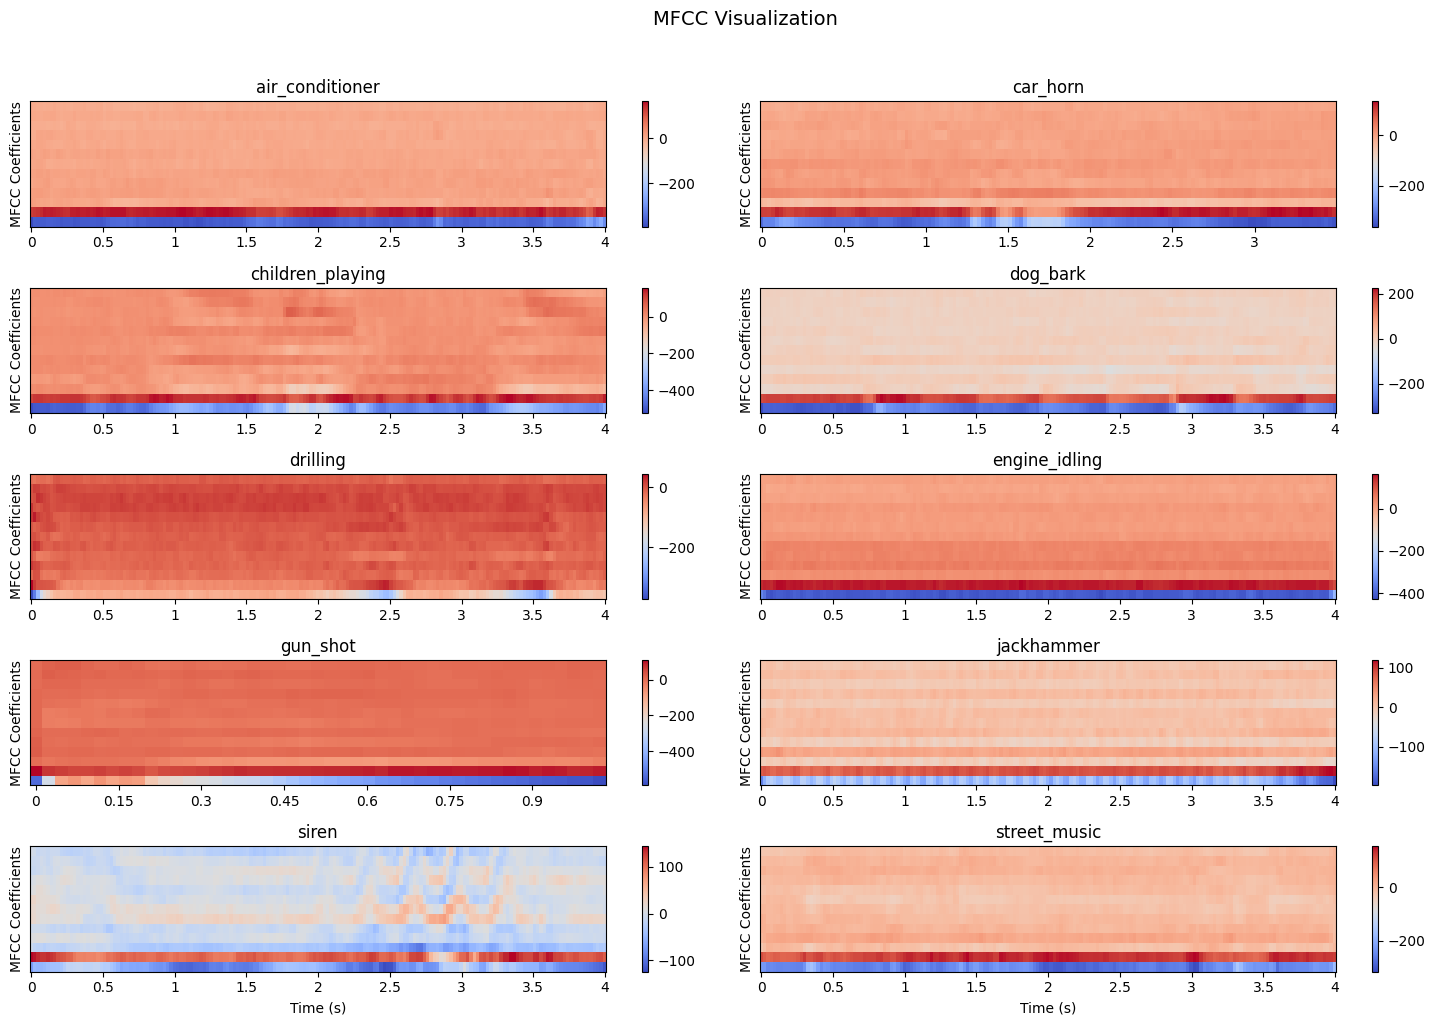

In [23]:
rows = (len(labels) + 1) // 2
fig, axs = plt.subplots(rows, 2, figsize=(15, 2 * rows))

for i, (path, label) in enumerate(zip(audio_files, labels)):
    y, sr = librosa.load(path)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    ax = axs[i // 2, i % 2] if rows > 1 else axs[i % 2]

    # Plot MFCC
    img = librosa.display.specshow(mfccs, sr=sr, x_axis='time', ax=ax)
    ax.set_title(label, fontsize=12)
    ax.set_xlabel('Time (s)' if i // 2 == rows - 1 else '', fontsize=10)
    ax.set_ylabel('MFCC Coefficients', fontsize=10)

    fig.colorbar(img, ax=ax)

# Remove empty subplots if needed
if len(labels) % 2 != 0:
    fig.delaxes(axs.flatten()[-1])

plt.suptitle('MFCC Visualization', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Dataset Preparation

In [ ]:

metadata_path = r"C:\Users\yashm\Downloads\New folder (2)\UrbanSound8K\metadata\UrbanSound8K.csv"
metadata = pd.read_csv(metadata_path)

# Sample while maintaining class distribution
metadata = metadata.groupby('class', group_keys=False).apply(lambda x: x.sample(frac=0.75, random_state=42))

base_dir = os.path.abspath(os.path.join(os.path.dirname(metadata_path), '..'))
TARGET_SR = 22050
DURATION = 2
MAX_LENGTH = TARGET_SR * DURATION
N_MELS = 64
HOP_LENGTH = 512  # Explicit definition for consistent feature dimensions

def preprocess_audio(file_path):
    try:
        audio, _ = librosa.load(file_path, sr=TARGET_SR, duration=DURATION, res_type='kaiser_fast')
        return np.pad(audio, (0, MAX_LENGTH - len(audio)), 'constant') if len(audio) < MAX_LENGTH else audio
    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")
        return None

def extract_features(audio):
    mel_spec = librosa.feature.melspectrogram(
        y=audio, sr=TARGET_SR, n_mels=N_MELS, hop_length=HOP_LENGTH
    )
    return librosa.power_to_db(mel_spec, ref=np.max)

mel_specs = []
labels = []
class_names = metadata['class'].unique()  # Gets classes present in sampled data

for _, row in metadata.iterrows():
    file_path = os.path.join(base_dir, 'audio', f'fold{row.fold}', row.slice_file_name)
    audio = preprocess_audio(file_path)
    if audio is not None:
        mel_spec = extract_features(audio)
        mel_specs.append(mel_spec)
        labels.append(np.where(class_names == row['class'])[0][0])  # Safe due to stratified sampling

# Ensure consistent shape for all spectrograms
max_time_steps = max(spec.shape[1] for spec in mel_specs)
X = np.array([
    np.pad(
        spec, 
        ((0, 0), (0, max_time_steps - spec.shape[1]))
    ) if spec.shape[1] < max_time_steps else spec
    for spec in mel_specs
])
X = np.expand_dims(X, axis=-1)  # Add channel dimension
y = to_categorical(np.array(labels))




C:\Users\yashm\AppData\Local\Temp\ipykernel_14616\729257250.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metadata = metadata.groupby('class', group_keys=False).apply(lambda x: x.sample(frac=0.75, random_state=42))


In [ ]:

# Phase 2:  Active Learning Engine

class ActiveLearner:
    def __init__(self, model, X_pool, y_pool):
        self.model = model
        self.X_pool = X_pool
        self.y_pool = y_pool
        self.class_weights = self._calculate_class_weights()
        
    def _calculate_class_weights(self):
        class_counts = np.sum(self.y_pool, axis=0)
        return {i: (1.0 / count) if count > 0 else 0.0 for i, count in enumerate(class_counts)}
    
    def _balanced_initial_sample(self, initial_size):
        sample_weights = np.array([self.class_weights[np.argmax(y)] for y in self.y_pool])
        sample_weights /= sample_weights.sum()
        return np.random.choice(
            len(self.X_pool), 
            size=min(initial_size, len(self.X_pool)),
            replace=False, 
            p=sample_weights
        )
    
    def uncertainty_sampling(self, n_queries=20):
        probs = self.model.predict(self.X_pool, verbose=0)
        return np.argsort(np.max(probs, axis=1))[:n_queries]
    
    def entropy_sampling(self, n_queries=20):
        probs = self.model.predict(self.X_pool, verbose=0)
        entropy = -np.sum(probs * np.log(probs + 1e-10), axis=1)
        return np.argsort(-entropy)[:n_queries]
    
    def run_learning(self, X_test, y_test, cycles=5, 
                    query_strategy='entropy',
                    query_size=25,
                    epochs_per_cycle=8,
                    batch_size=32):
        
        initial_idx = self._balanced_initial_sample(100)
        X_train = self.X_pool[initial_idx]
        y_train = self.y_pool[initial_idx]
        
        # Remove selected samples from pool
        mask = np.ones(len(self.X_pool), dtype=bool)
        mask[initial_idx] = False
        self.X_pool = self.X_pool[mask]
        self.y_pool = self.y_pool[mask]
        
        acc_history = []
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        
        for cycle in range(cycles):
            print(f"\nCycle {cycle+1}/{cycles}")
            
            # Create new optimizer with schedule for each cycle
            self.model.optimizer = tf.keras.optimizers.Adam(
                learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
                    0.001, decay_steps=100, decay_rate=0.96
                )
            )
            
            self.model.fit(
                X_train, y_train,
                validation_data=(X_test, y_test),
                epochs=epochs_per_cycle,
                batch_size=batch_size,
                callbacks=[early_stop],
                class_weight=self.class_weights,
                verbose=1
            )
            
            if query_strategy == 'uncertainty':
                query_idx = self.uncertainty_sampling(query_size)
            elif query_strategy == 'entropy':
                query_idx = self.entropy_sampling(query_size)
            else:
                query_idx = np.random.choice(len(self.X_pool), query_size, replace=False)
            
            # Update training set and pool
            X_train = np.concatenate([X_train, self.X_pool[query_idx]])
            y_train = np.concatenate([y_train, self.y_pool[query_idx]])
            
            mask = np.ones(len(self.X_pool), dtype=bool)
            mask[query_idx] = False
            self.X_pool = self.X_pool[mask]
            self.y_pool = self.y_pool[mask]
            
            loss, acc = self.model.evaluate(X_test, y_test, verbose=0)
            acc_history.append(acc)
            print(f"Test Accuracy: {acc:.3f} | Samples used: {len(X_train)}")
        
        return acc_history


In [ ]:

# Phase 3:CNN Model Architecture

def create_advanced_model(input_shape, num_classes):
    model = Sequential([
        RandomFlip("horizontal", input_shape=input_shape),
        RandomRotation(0.1),
        RandomZoom(0.1),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Conv2D(256, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(512, activation='relu', kernel_regularizer='l2'),
        Dropout(0.5),
        Dense(256, activation='relu', kernel_regularizer='l2'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),  # Will be replaced in learning cycles
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )
    return model




In [ ]:
# Phase 4:  Execution Pipeline

X_pool_al, X_test_al, y_pool_al, y_test_al = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

input_shape = X_pool_al.shape[1:]
num_classes = y_pool_al.shape[1]

advanced_model = create_advanced_model(input_shape, num_classes)

learner = ActiveLearner(advanced_model, X_pool_al, y_pool_al)
al_accuracies = learner.run_learning(
    X_test_al, 
    y_test_al,
    cycles=5,
    query_strategy='entropy',
    query_size=25,
    epochs_per_cycle=8,
    batch_size=32
)

# Phase 5: Performance Analysis-
print("\nFinal Active Learning Performance:")
print(f"Best Accuracy: {max(al_accuracies):.3f}")
print(f"Accuracy Trend: {[round(acc, 3) for acc in al_accuracies]}")

In [ ]:
# Passive Learning Implementation

In [ ]:

passive_model = create_advanced_model(input_shape, num_classes)

class PassiveLearner:
    def __init__(self, model, X_pool, y_pool):
        self.model = model
        self.X_pool = X_pool
        self.y_pool = y_pool
        self.class_weights = self._calculate_class_weights()
        
    def _calculate_class_weights(self):
        class_counts = np.sum(self.y_pool, axis=0)
        return {i: (1.0 / count) if count > 0 else 0.0 for i, count in enumerate(class_counts)}
    
    def _random_initial_sample(self, initial_size):
        return np.random.choice(
            len(self.X_pool), 
            size=min(initial_size, len(self.X_pool)),
            replace=False
        )
    
    def run_learning(self, X_test, y_test, cycles=5,
                    query_size=25,
                    epochs_per_cycle=8,
                    batch_size=32):
        
        initial_idx = self._random_initial_sample(100)
        X_train = self.X_pool[initial_idx]
        y_train = self.y_pool[initial_idx]
        
        
        mask = np.ones(len(self.X_pool), dtype=bool)
        mask[initial_idx] = False
        self.X_pool = self.X_pool[mask]
        self.y_pool = self.y_pool[mask]
        
        acc_history = []
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        
        for cycle in range(cycles):
            print(f"\nPassive Learning Cycle {cycle+1}/{cycles}")
            
          
            self.model.optimizer = tf.keras.optimizers.Adam(
                learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
                    0.001, decay_steps=100, decay_rate=0.96
                )
            )
            
            self.model.fit(
                X_train, y_train,
                validation_data=(X_test, y_test),
                epochs=epochs_per_cycle,
                batch_size=batch_size,
                callbacks=[early_stop],
                class_weight=self.class_weights,
                verbose=1
            )
            
           
            query_idx = np.random.choice(
                len(self.X_pool), 
                size=min(query_size, len(self.X_pool)), 
                replace=False
            )
            
            # Update training set and pool
            X_train = np.concatenate([X_train, self.X_pool[query_idx]])
            y_train = np.concatenate([y_train, self.y_pool[query_idx]])
            
            mask = np.ones(len(self.X_pool), dtype=bool)
            mask[query_idx] = False
            self.X_pool = self.X_pool[mask]
            self.y_pool = self.y_pool[mask]
            
            loss, acc = self.model.evaluate(X_test, y_test, verbose=0)
            acc_history.append(acc)
            print(f"Test Accuracy: {acc:.3f} | Samples used: {len(X_train)}")
        
        return acc_history

# Execute passive learning
passive_learner = PassiveLearner(passive_model, X_pool_al, y_pool_al)
passive_accuracies = passive_learner.run_learning(
    X_test_al, 
    y_test_al,
    cycles=5,
    query_size=25,
    epochs_per_cycle=8,
    batch_size=32
)



In [ ]:
# Comparative Performance Analysis

print("\nModel Performance Comparison:")
print(f"Active Learning Accuracies: {[round(acc, 3) for acc in al_accuracies]}")
print(f"Passive Learning Accuracies: {[round(acc, 3) for acc in passive_accuracies]}")
print(f"Final Active Learning Accuracy: {al_accuracies[-1]:.3f}")
